In [50]:
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
import scipy.stats as stats
import pylab
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elikplim/forest-fires-data-set")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/elikplim/forest-fires-data-set/versions/1


In [32]:
import pandas as pd
forestfires = pd.read_csv(path + '/forestfires.csv')

In [4]:
forestfires.dtypes

,0
X,int64
Y,int64
month,object
day,object
FFMC,float64
DMC,float64
DC,float64
ISI,float64
temp,float64
RH,int64


In [5]:
forestfires.isna().sum()

,0
X,0
Y,0
month,0
day,0
FFMC,0
DMC,0
DC,0
ISI,0
temp,0
RH,0


# Exploratory data analysis

In [6]:
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [7]:
forestfires.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


# Dependent variable

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


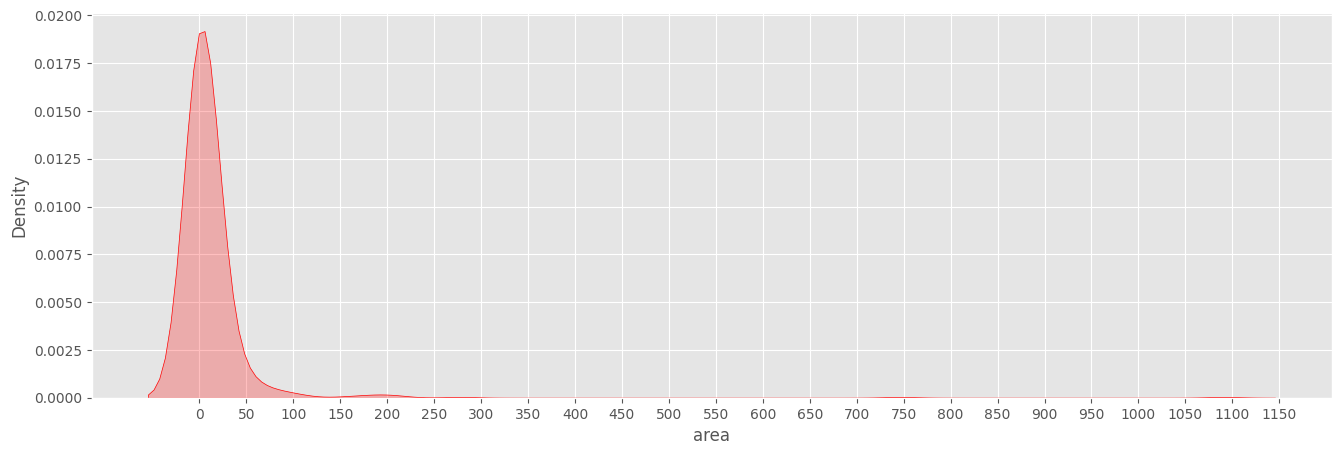

In [8]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(forestfires['area'].skew()))
print("Kurtosis: {}".format(forestfires['area'].kurtosis()))
ax = sns.kdeplot(data=forestfires['area'], fill=True,color='red')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

- Skewness: A skewness of 12.85 indicates the distribution is highly positively skewed, meaning most area values are clustered on the lower end, with a few very high values pulling the tail to the right.
- Kurtosis: A kurtosis of 194.14 indicates extremely heavy tails, meaning the data has a few extreme outliers.
- Kernel density estimation: Most of the observations are concentrated near zero, and only a few areas have very high values.

# Independent variable

In [9]:
numeric_columns = ['FFMC','DMC','DC','ISI','temp','RH','wind','rain']
num_data = forestfires[numeric_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


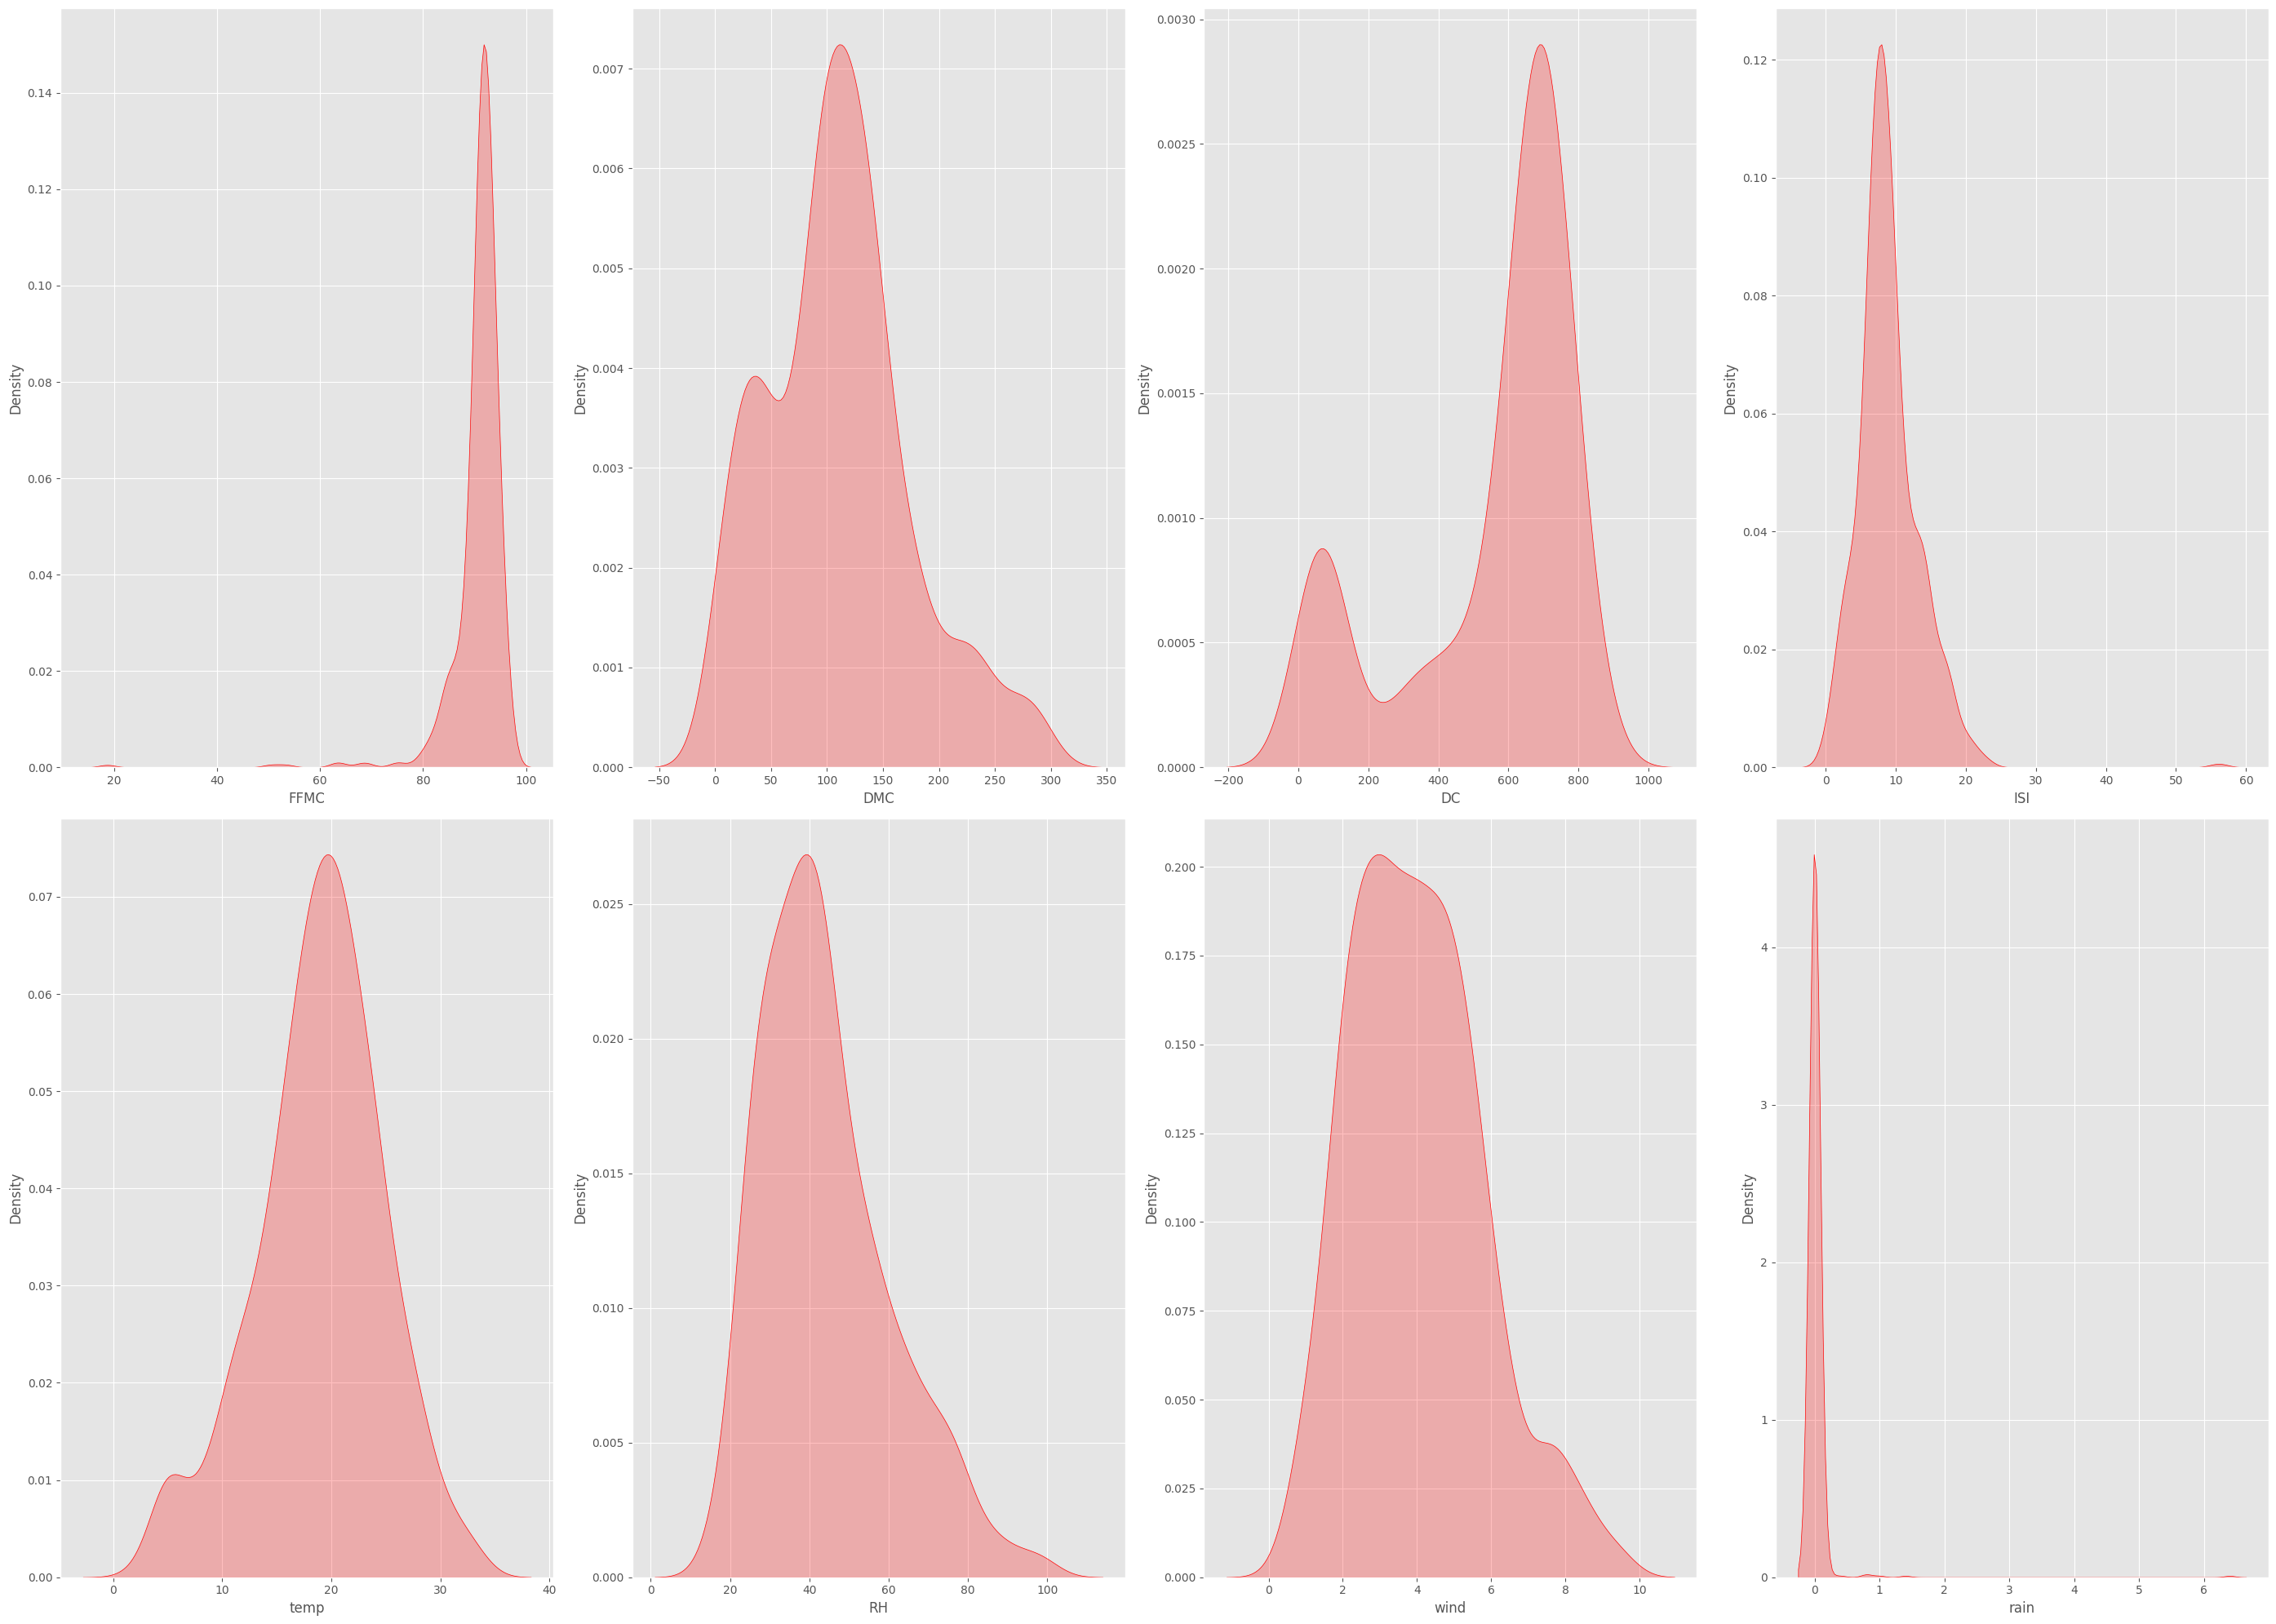

In [10]:
plt.figure(figsize=(28,20))
for i,col in enumerate(numeric_columns,1):
    plt.subplot(2,4,i)
    sns.kdeplot(forestfires[col],color='r',fill=True)
plt.tight_layout()
plt.show()

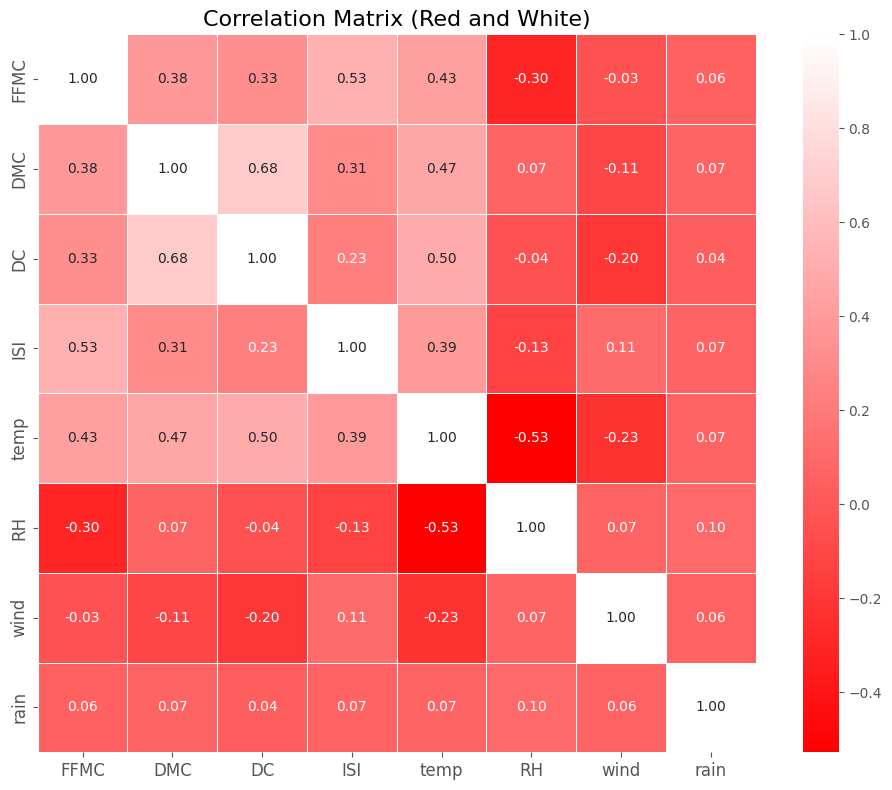

In [11]:
id_forestfires = forestfires[['FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
correlation_matrix = id_forestfires.corr()
red_black_cmap = LinearSegmentedColormap.from_list("RedBlack", ["red", "white"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap=red_black_cmap,
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Matrix (Red and White)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


# Degree of Damage by Time

In [12]:
time_columns = forestfires[['month','day']]

In [13]:
def area_damage(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

forestfires['Degree_of_damage'] = forestfires['area'].apply(area_damage)
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Degree_of_damage
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


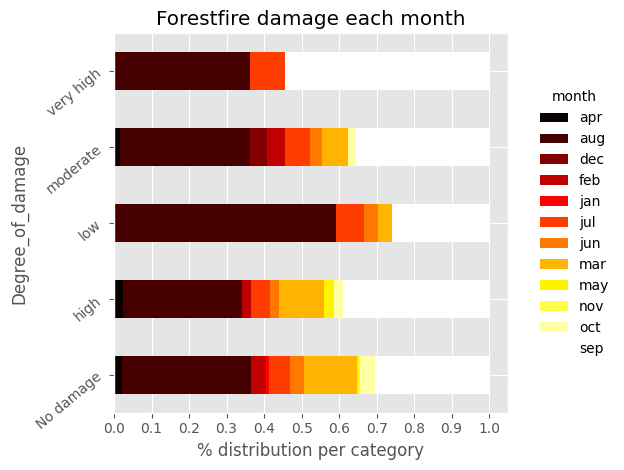

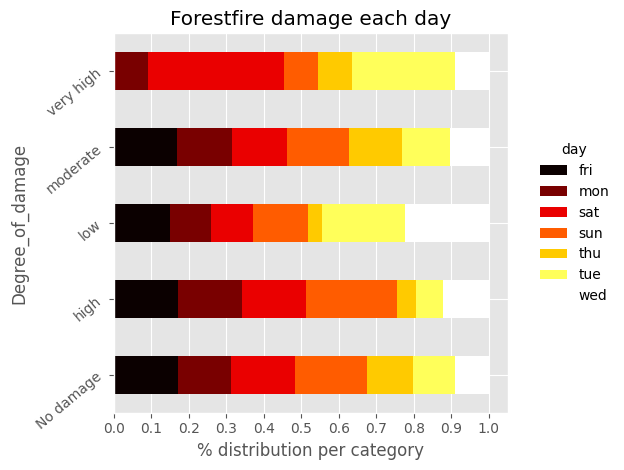

In [14]:
for column in time_columns:
    cross = pd.crosstab(index=forestfires['Degree_of_damage'], columns=forestfires[column], normalize='index')
    ax = cross.plot.barh(stacked=True, rot=40, cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title(f"Forestfire damage each {column}")
    # Move the legend to the right
    plt.legend(title=column, bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False)
    plt.tight_layout()
plt.show()

# Fire frequency per coordinate analysis

In [23]:
forestfires

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,22
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,27
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,45
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,15


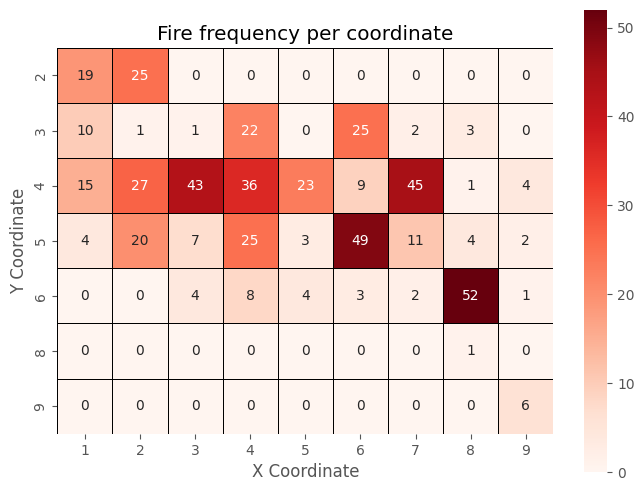

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Cap the maximum area value and bin into custom ranges
forestfires["area"] = np.clip(forestfires["area"], 0, 1090)
bins = [0,1200]  # Define custom bins
forestfires["area_bins"] = pd.cut(forestfires["area"], bins=bins, right=False)

# Create a 9x9 heatmap for each bin
for bin_range in forestfires["area_bins"].cat.categories:
    # Filter data for the current bin range
    filtered_data = forestfires[forestfires["area_bins"] == bin_range]

    # Create a pivot table for counts of data points in the grid
    heatmap_data = filtered_data.pivot_table(
        index="Y", columns="X", values="area", aggfunc="count", fill_value=0
    )

    # Plot the heatmap for the current bin
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar=True,
        linewidths=0.5,
        linecolor="black",
        square=True,
        vmin=0,  # Ensure consistent color scaling across bins
    )
    plt.title("Fire frequency per coordinate")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [25]:
filtered_data

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,22
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,27
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,45
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,15


# Outliers

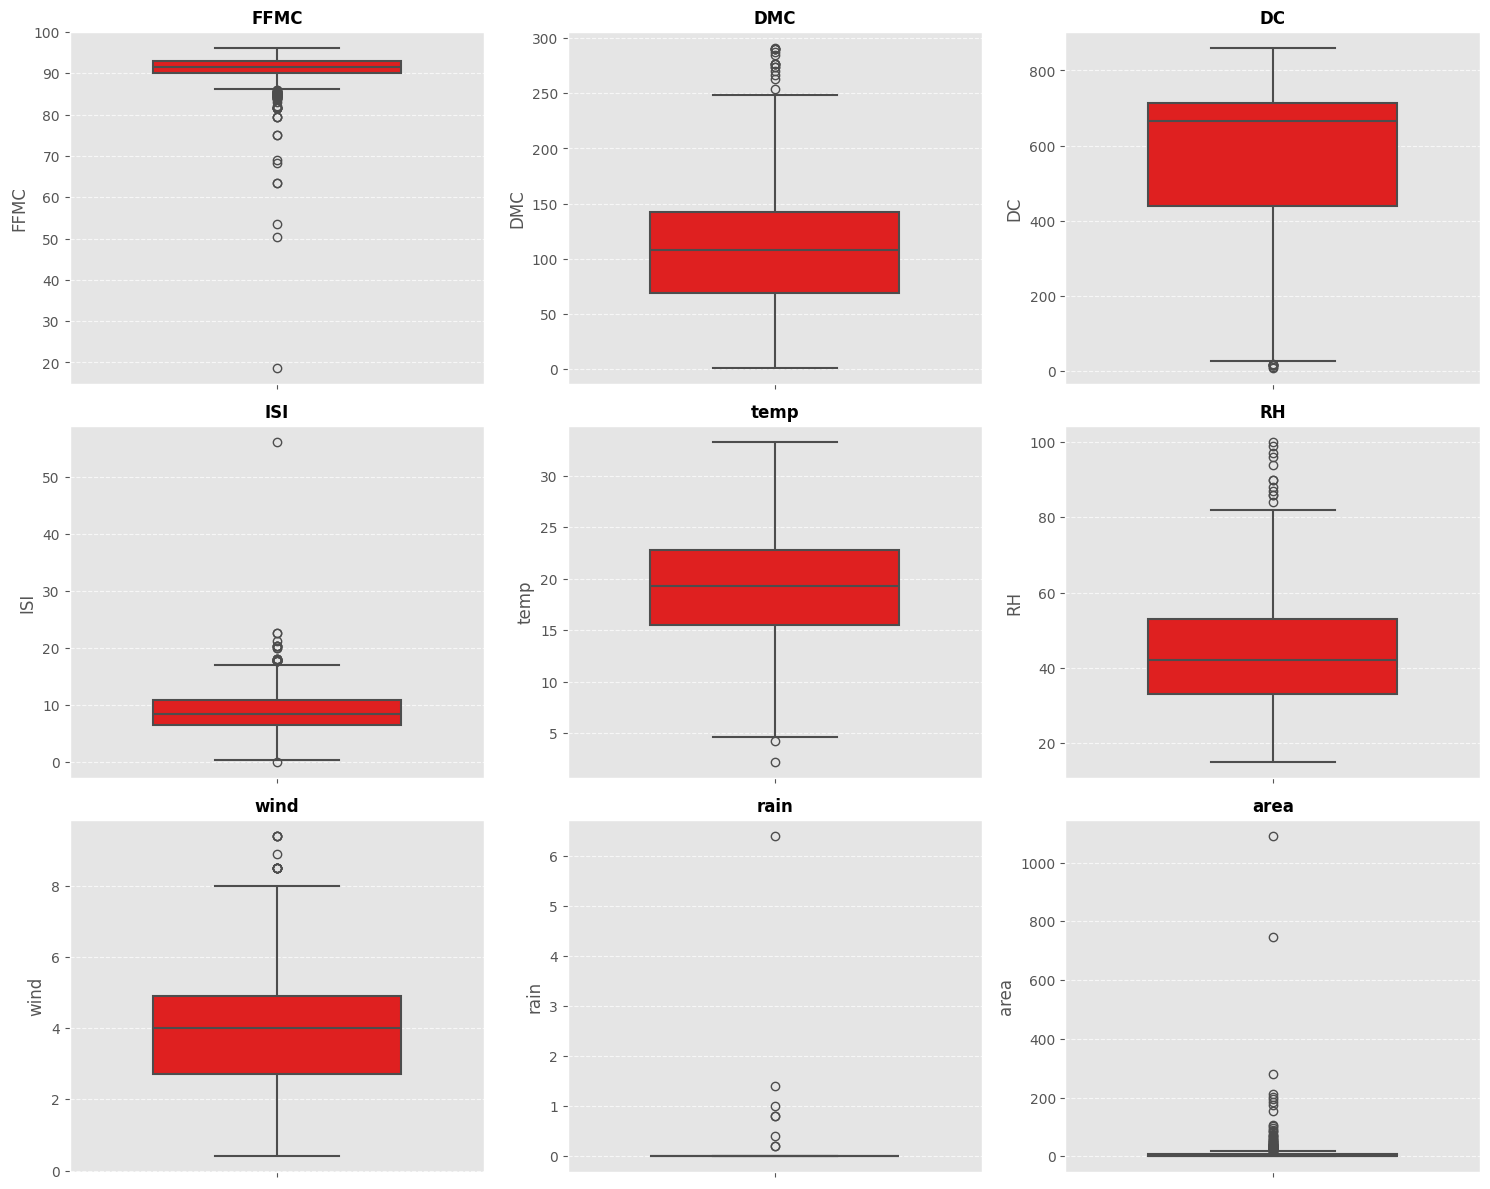

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
numeric_columns = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

# Create boxplots for each numerical column using Seaborn for better styling
plt.figure(figsize=(15, 12))  # Increase figure size for better spacing
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  # Arrange in a 3x3 grid
    sns.boxplot(data=forestfires[col], color="red", width=0.6, linewidth=1.5)
    plt.title(col, fontsize=12, fontweight="bold")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

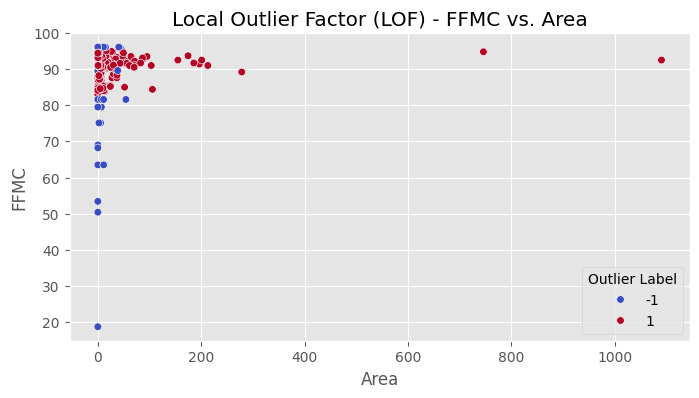


Outliers for variable FFMC:

      area  FFMC
12    0.00  63.5
40    0.00  79.5
95    0.00  89.7
97    0.00  69.0
104   0.00  82.1
112   0.00  89.7
130   0.00  68.2
164   2.01  89.7
167   2.51  96.0
176   4.61  81.5
188   7.40  90.8
196  10.93  81.5
199  11.32  63.5
239   0.00  81.9
299   0.00  53.4
305   0.00  89.6
306   0.41  89.6
307   5.18  89.6
312   0.00  50.4
379   0.00  18.7
416   7.02  92.7
430   0.00  89.7
435   0.00  90.8
437   0.00  89.4
448   0.00  89.7
453   0.00  89.4
463   5.39  75.1
464   2.14  75.1
465   6.84  79.5
471  38.48  89.6
491   0.00  95.8
492   0.00  95.9
493  43.32  95.9
494   8.59  96.0
495   0.00  96.2
496   2.77  96.2
497  14.68  96.1
498  40.54  96.1
499  10.82  96.1
500   0.00  96.1
501   0.00  96.1
502   0.00  96.1
511   0.00  81.6
512   6.44  81.6
513  54.29  81.6
514  11.16  81.6
516   0.00  79.5


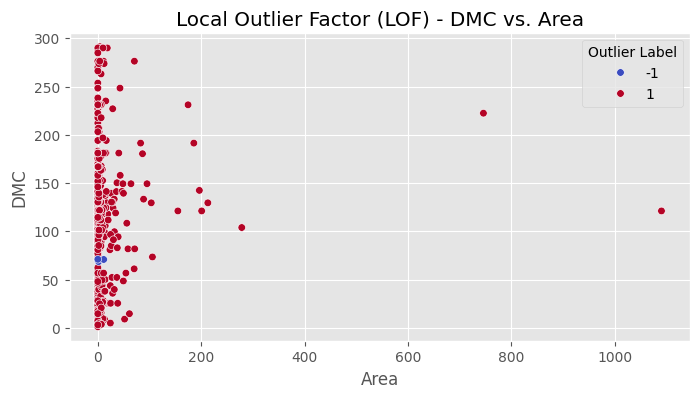


Outliers for variable DMC:

      area   DMC
12    0.00  70.8
32    0.00  69.7
151   1.36  68.6
199  11.32  70.8
299   0.00  71.0


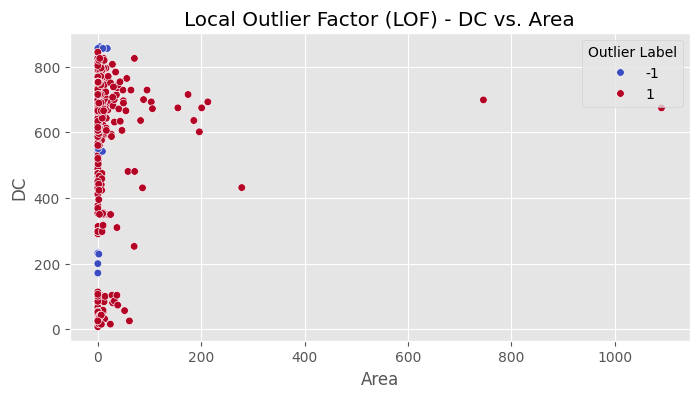


Outliers for variable DC:

      area     DC
22    0.00  200.0
23    0.00  537.4
260   8.85  542.0
265   0.79  550.3
299   0.00  233.8
302   0.00  232.1
303   0.00  232.1
374  18.30  855.3
379   0.00  171.4
406   3.95  860.6
408   7.80  855.3
440   0.00  855.3
444   9.96  855.3
472   1.94  229.0


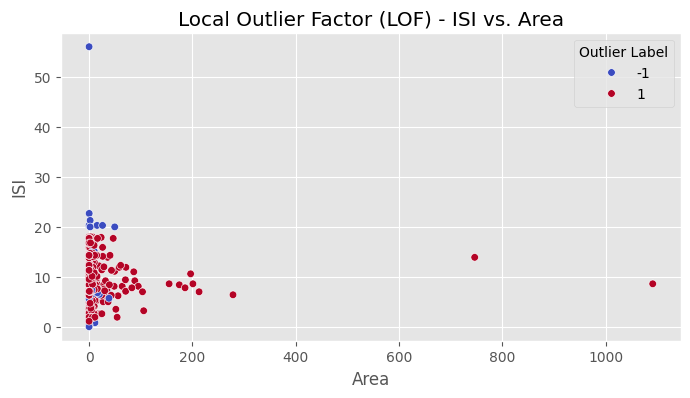


Outliers for variable ISI:

      area   ISI
1     0.00   6.7
2     0.00   6.7
11    0.00  22.6
12    0.00   0.8
22    0.00  56.1
24    0.00  20.3
32    0.00   5.8
36    0.00   6.7
38    0.00   6.7
64    0.00   5.8
94    0.00   5.8
97    0.00   0.7
130   0.00   0.8
135   0.00  20.3
171   2.69   6.6
184   6.96  15.1
189   8.24   5.5
195  10.02  15.1
199  11.32   0.8
206  15.45  20.3
210  24.23   6.7
211  26.00  20.3
223  37.02   6.8
266   0.17  22.7
273   8.98   6.8
299   0.00   0.4
305   0.00   5.7
306   0.41   5.7
307   5.18   5.7
312   0.00   0.4
323   2.18   6.8
341   0.00   6.5
363   2.93   6.5
364   5.65   6.5
365  20.03   6.5
379   0.00   0.0
381  16.33   6.8
403   0.00   6.8
430   0.00   6.8
434   0.00   5.5
435   0.00   5.6
453   0.00   5.6
467   5.55   7.3
471  38.48   5.7
485   2.07  21.3
503   1.95  20.0
504  49.59  20.0


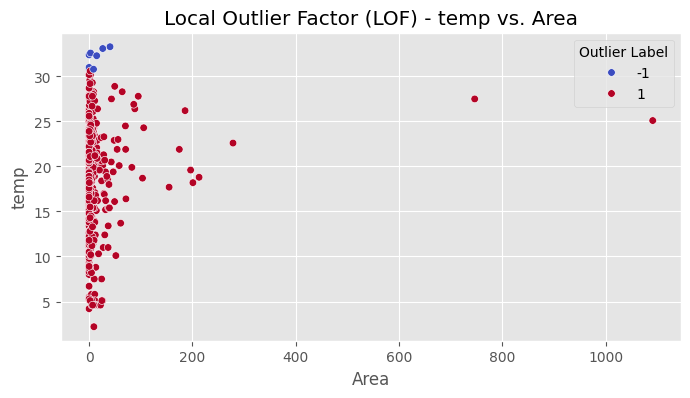


Outliers for variable temp:

      area  temp
421   0.00  30.8
483   0.00  31.0
484  26.43  33.1
491   0.00  32.4
492   0.00  32.4
494   8.59  30.8
496   2.77  32.6
497  14.68  32.3
498  40.54  33.3


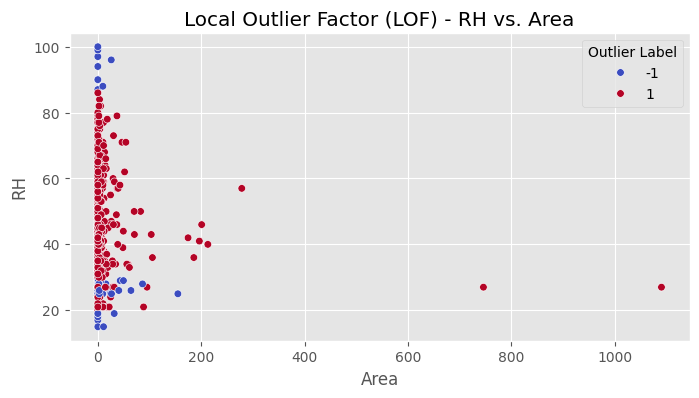


Outliers for variable RH:

       area   RH
3      0.00   97
4      0.00   99
5      0.00   29
50     0.00   17
69     0.00   26
72     0.00   25
79     0.00   19
85     0.00   15
89     0.00   25
98     0.00   87
103    0.00   29
106    0.00   29
111    0.00   18
147    0.96   28
149    1.12   25
151    1.36   29
160    1.75   29
168    2.53   26
191    8.68   28
193    9.41   25
197   11.06   15
209   23.41   26
210   24.23   25
211   26.00   96
218   31.72   19
228   64.10   26
234  154.88   25
248    0.00   28
250    0.68   25
286    0.00   90
293   86.45   28
299    0.00   90
300    0.00   25
304    0.00   94
311   14.29   28
319    4.41   28
321    7.21   28
322    1.01   28
331   15.64   28
379    0.00  100
382    5.86   29
393    0.00   19
421    0.00   19
441    1.23   29
451    9.71   88
476    1.76   28
480    2.75   25
484   26.43   25
485    2.07   28
493   43.32   29
496    2.77   26
498   40.54   26
504   49.59   29


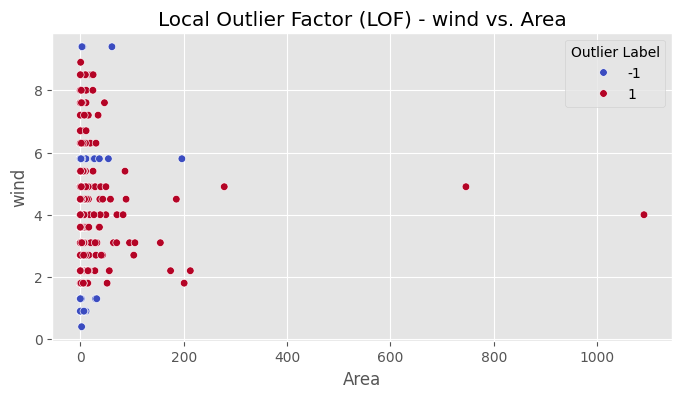


Outliers for variable wind:

       area  wind
1      0.00   0.9
2      0.00   1.3
23     0.00   5.8
24     0.00   5.8
26     0.00   5.8
27     0.00   1.3
49     0.00   5.8
50     0.00   1.3
59     0.00   0.9
60     0.00   5.8
74     0.00   1.3
83     0.00   0.9
85     0.00   0.9
90     0.00   5.8
95     0.00   1.3
110    0.00   5.8
129    0.00   0.9
135    0.00   5.8
136    0.00   1.3
155    1.56   1.3
159    1.69   5.8
166    2.29   0.9
168    2.53   9.4
176    4.61   5.8
186    7.19   5.8
188    7.40   0.9
196   10.93   5.8
197   11.06   0.9
211   26.00   5.8
213   27.35   5.8
216   29.48   1.3
218   31.72   1.3
222   36.85   5.8
235  196.48   5.8
249    2.47   0.4
258    0.00   0.9
291    8.00   0.9
292    2.64   1.3
295    0.00   1.3
316    0.00   5.8
372    0.00   0.9
378    0.00   5.8
379    0.00   0.9
411    4.62   9.4
417    0.00   5.8
428    0.00   5.8
436    0.54   1.3
465    6.84   0.9
466    3.18   5.8
469   61.13   9.4
470    0.00   5.8
475    3.19   9.4
476    1.76   1.

In [33]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# List of variables for LOF analysis
variables = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']

# Number of neighbors to consider in LOF
n_neighbors = 30

# Initialize dictionaries to store LOF scores and outlier information
lof_scores = {}
outlier_areas = {}

# Loop through each variable to calculate LOF and visualize results
for var in variables:
    # Apply Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=n_neighbors)
    forestfires[f'lof_{var}'] = lof.fit_predict(forestfires[[var]])  # LOF prediction (-1 for outliers)
    forestfires[f'lof_score_{var}'] = -lof.negative_outlier_factor_  # LOF scores (negative for better visualization)

    # Identify outliers
    outliers = forestfires[forestfires[f'lof_{var}'] == -1]
    outlier_areas[var] = outliers[['area', var]]  # Store area and variable value of outliers

    # Plot LOF visualization for the variable with area on x-axis
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=forestfires, x='area', y=forestfires[var],
                    hue=forestfires[f'lof_{var}'], palette="coolwarm", s=30)
    plt.title(f"Local Outlier Factor (LOF) - {var} vs. Area")
    plt.xlabel("Area")
    plt.ylabel(var)
    plt.legend(title="Outlier Label")
    plt.grid(True)
    plt.show()

    # Print outlier information
    print(f"\nOutliers for variable {var}:\n")
    print(outlier_areas[var])

# Combine outlier information from all variables into a single DataFrame
all_outliers_combined = pd.concat(outlier_areas.values(), keys=outlier_areas.keys())

# Data summary: Check for missing or invalid data in the variables
missing_data_summary = forestfires[variables].isnull().sum()
valid_data_summary = forestfires[variables].notnull().sum()

# Display a summary of missing and valid data
data_summary = pd.DataFrame({
    "Variable": variables,
    "Missing Data": missing_data_summary.values,
    "Valid Data": valid_data_summary.values
})

# Classification

In [34]:
def area_damage(area):
    if area == 0.0:
        return "No damage"
    else:
        return "damaged"

forestfires['Degree_of_damage'] = forestfires['area'].apply(area_damage)
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,...,lof_score_DC,lof_ISI,lof_score_ISI,lof_temp,lof_score_temp,lof_RH,lof_score_RH,lof_wind,lof_score_wind,Degree_of_damage
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,...,1.015650,1,1.104526,1,1.389035,1,1.000000,1,1.011246e+00,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,...,0.955600,-1,2.010559,1,0.999043,1,1.000000,-1,7.300000e+08,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,...,0.998837,-1,2.010559,1,1.012316,1,1.000000,-1,8.977778e+08,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,...,0.965712,1,1.025091,1,1.398882,-1,2.292796,1,1.000000e+00,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,...,1.047287,1,0.989901,1,0.983024,-1,2.463835,1,1.000000e+00,No damage


In [35]:
forestfires = pd.get_dummies(forestfires,columns=['day','month'],drop_first=True)
forestfires = forestfires.astype({col: 'int' for col in forestfires.select_dtypes('bool').columns})
forestfires.head()


,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,1,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,1,0,0,0,0


In [36]:
# Step 1: Calculate the frequency of each (X, Y) coordinate
coordinate_freq = forestfires.groupby(['X', 'Y']).size().reset_index(name='coordinate_count')

# Step 2: Merge the frequency back into the original dataframe
forestfires = forestfires.merge(coordinate_freq, on=['X', 'Y'], how='left')

# Step 3: Display the updated dataframe with the new 'coordinate_count' column
forestfires.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52


In [39]:
forestfires

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,22
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,27
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,45
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,15


In [52]:
# Step 2: Define independent variables (X) and target variable (y)
X = forestfires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']]
y = forestfires['Degree_of_damage'].map({'No damage': 0, 'damaged': 1})  # Convert target to numeric

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Define parameter grid for Logistic Regression
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear'],  # Solvers to try
    'penalty': ['l1', 'l2'],  # Regularization types
    'max_iter': [100, 200, 300]  # Number of iterations
}

# Step 6: Initialize Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Step 7: Perform GridSearchCV for Logistic Regression
log_reg_grid_search = GridSearchCV(
    estimator=log_reg_model,
    param_grid=log_reg_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1,
    error_score=np.nan
)
log_reg_grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best Logistic Regression model
log_reg_best_model = log_reg_grid_search.best_estimator_
y_pred_log_reg = log_reg_best_model.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg)

# Step 9: Display results
print("Logistic Regression Best Parameters:", log_reg_grid_search.best_params_)
print("\nLogistic Regression Accuracy:", accuracy_log_reg)
print("\nLogistic Regression Classification Report:\n", report_log_reg)

# Logistic Regression Coefficients
log_reg_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg_best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print("\nLogistic Regression Feature Coefficients:\n", log_reg_feature_importance)

Logistic Regression Best Parameters: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Accuracy: 0.5576923076923077

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.33      0.42        51
           1       0.55      0.77      0.64        53

    accuracy                           0.56       104
   macro avg       0.57      0.55      0.53       104
weighted avg       0.57      0.56      0.53       104


Logistic Regression Feature Coefficients:
   Feature  Coefficient
0    FFMC     0.216875
6    wind     0.170475
2      DC     0.142986
4    temp     0.098408
5      RH     0.037338
1     DMC    -0.014629
3     ISI    -0.125323


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


# Step 2: Define features (X) and target variable (y)
X = forestfires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']]
y = forestfires['Degree_of_damage'].map({'No damage': 0, 'damaged': 1})  # Convert target to numeric

# Step 3: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Define parameter grid for SVM
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],          # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],   # Kernel types
    'gamma': ['scale', 'auto'],            # Kernel coefficient
    'degree': [2, 3, 4]                    # Degree for 'poly' kernel
}

# Step 6: Initialize the SVM model
svm_model = SVC(random_state=42)

# Step 7: Perform GridSearchCV to find the best hyperparameters
svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,  # Show progress
    n_jobs=-1   # Use all available cores
)
svm_grid_search.fit(X_train, y_train)

# Step 8: Evaluate the best SVM model
svm_best_model = svm_grid_search.best_estimator_
y_pred_svm = svm_best_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# Step 9: Display results
print("SVM Best Parameters:", svm_grid_search.best_params_)
print("\nSVM Accuracy:", accuracy_svm)
print("\nSVM Classification Report:\n", report_svm)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVM Best Parameters: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}

SVM Accuracy: 0.5384615384615384

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.29      0.38        51
           1       0.53      0.77      0.63        53

    accuracy                           0.54       104
   macro avg       0.54      0.53      0.51       104
weighted avg       0.54      0.54      0.51       104



In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


# Step 2: Define features (X) and target variable (y)
X = forestfires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'coordinate_count']]
y = forestfires['Degree_of_damage'].map({'No damage': 0, 'damaged': 1})  # Convert target to numeric

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],        # Splitting criterion
    'max_depth': [None, 5, 10, 20],          # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split
    'min_samples_leaf': [1, 2, 4]            # Minimum samples required at leaf node
}

# Step 6: Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Step 7: Perform GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=dt_param_grid,
    cv=5,                                     # 5-fold cross-validation
    scoring='accuracy',
    verbose=1,                                # Display GridSearchCV progress
    n_jobs=-1                                 # Use all available cores
)
dt_grid_search.fit(X_train_scaled, y_train)

# Step 8: Evaluate the best Decision Tree model
dt_best_model = dt_grid_search.best_estimator_
y_pred_dt = dt_best_model.predict(X_test_scaled)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

# Step 9: Display results
print("Decision Tree Best Parameters:", dt_grid_search.best_params_)
print("\nDecision Tree Accuracy:", accuracy_dt)
print("\nDecision Tree Classification Report:\n", report_dt)

# Step 10: Feature importance
dt_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nDecision Tree Feature Importance:\n", dt_feature_importance)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Decision Tree Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}

Decision Tree Accuracy: 0.5288461538461539

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.71      0.60        51
           1       0.56      0.36      0.44        53

    accuracy                           0.53       104
   macro avg       0.54      0.53      0.52       104
weighted avg       0.54      0.53      0.51       104


Decision Tree Feature Importance:
             Feature  Importance
7  coordinate_count    0.202738
5                RH    0.131458
1               DMC    0.127556
2                DC    0.125520
4              temp    0.120116
6              wind    0.118209
3               ISI    0.090111
0              FFMC    0.084293


In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Step 1: Load and prepare data
forestfires

# Step 2: Define features (X) and target variable (y)
X = forestfires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'coordinate_count']]
y = forestfires['Degree_of_damage'].map({'No damage': 0, 'damaged': 1})  # Convert target to numeric

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define parameter grids for GridSearchCV

# Random Forest parameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# AdaBoost parameter grid
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# LightGBM parameter grid
lgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

# Step 6: Define models
rf_model = RandomForestClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
lgb_model = LGBMClassifier(random_state=42)

# Step 7: Perform GridSearchCV for RandomForest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

# Step 8: Perform GridSearchCV for AdaBoost
ada_grid_search = GridSearchCV(estimator=ada_model, param_grid=ada_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
ada_grid_search.fit(X_train_scaled, y_train)

# Step 9: Perform GridSearchCV for LightGBM
lgb_grid_search = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
lgb_grid_search.fit(X_train_scaled, y_train)

# Step 10: Evaluate the best models

# Random Forest
rf_best_model = rf_grid_search.best_estimator_
y_pred_rf = rf_best_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

# AdaBoost
ada_best_model = ada_grid_search.best_estimator_
y_pred_ada = ada_best_model.predict(X_test_scaled)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
report_ada = classification_report(y_test, y_pred_ada)

# LightGBM
lgb_best_model = lgb_grid_search.best_estimator_
y_pred_lgb = lgb_best_model.predict(X_test_scaled)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)

# Step 11: Display results
print("Random Forest Best Parameters:", rf_grid_search.best_params_)
print("\nRandom Forest Accuracy:", accuracy_rf)
print("\nRandom Forest Classification Report:\n", report_rf)

print("\nAdaBoost Best Parameters:", ada_grid_search.best_params_)
print("\nAdaBoost Accuracy:", accuracy_ada)
print("\nAdaBoost Classification Report:\n", report_ada)

print("\nLightGBM Best Parameters:", lgb_grid_search.best_params_)
print("\nLightGBM Accuracy:", accuracy_lgb)
print("\nLightGBM Classification Report:\n", report_lgb)

# Step 12: Feature importance for each model
# Random Forest Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nRandom Forest Feature Importance:\n", rf_feature_importance)

# AdaBoost Feature Importance (based on decision trees used)
ada_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': ada_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nAdaBoost Feature Importance:\n", ada_feature_importance)

# LightGBM Feature Importance
lgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nLightGBM Feature Importance:\n", lgb_feature_importance)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 217, number of negative: 196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 413, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525424 -> initscore=0.101783
[LightGBM] [Info] Start training from score 0.101783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 217, number of negative: 196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 413, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525424 -> initscore=0.101783
[LightGBM] [Info] Start training from score 0.101783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

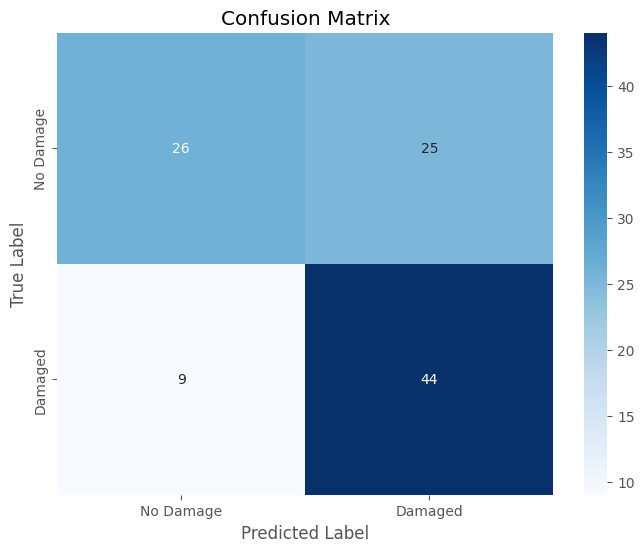

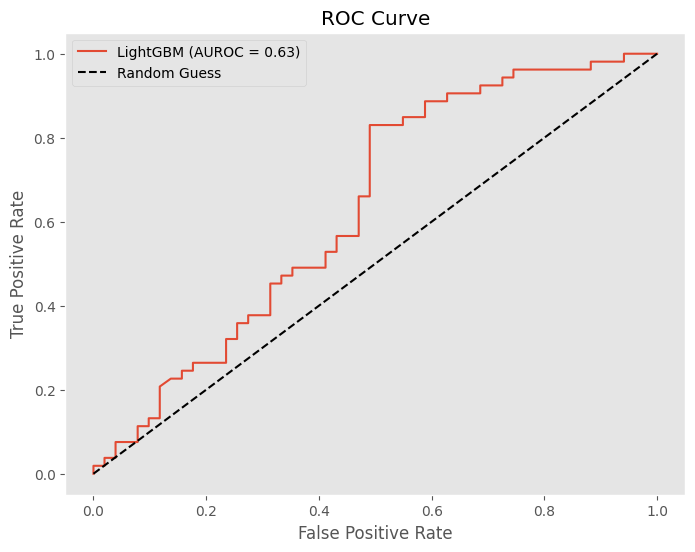

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Define independent variables (X) and target variable (y)
X = forestfires[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'coordinate_count']]
y = forestfires['Degree_of_damage'].map({'No damage': 0, 'damaged': 1})  # Convert target to numeric

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Define parameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of the trees
    'num_leaves': [31, 50, 100],  # Number of leaves in one tree
    'subsample': [0.8, 1.0],  # Subsample ratio of the training data
}

# Step 6: Initialize LightGBM model
lgb_model = LGBMClassifier(random_state=42)

# Step 7: Perform GridSearchCV for LightGBM
lgb_grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=lgb_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
lgb_grid_search.fit(X_train_scaled, y_train)

# Step 8: Evaluate the best LightGBM model
lgb_best_model = lgb_grid_search.best_estimator_
y_pred_lgb = lgb_best_model.predict(X_test_scaled)
y_prob_lgb = lgb_best_model.predict_proba(X_test_scaled)[:, 1]  # Predicted probabilities for positive class
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_lgb)

# AUROC
auroc = roc_auc_score(y_test, y_prob_lgb)

# Step 9: Display results
print("LightGBM Best Parameters:", lgb_grid_search.best_params_)
print("\nLightGBM Accuracy:", accuracy_lgb)
print("\nLightGBM Classification Report:\n", report_lgb)
print("\nLightGBM AUROC:", auroc)

# Feature importance
lgb_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nLightGBM Feature Importance:\n", lgb_feature_importance)

# Step 10: Visualizations

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Damage', 'Damaged'], yticklabels=['No Damage', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUROC = {auroc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Decision Tree,Randrom forest,Adaboost,Xgboost

# Gradient Boosting

### 1. Initial Model Training
First, we train an initial model $F_0(x)$, which can start as a simple model that predicts the mean value.

$$
F_0(x) = \arg \min_{\gamma} \sum_{i=1}^N L(y_i, \gamma)
$$

where:

- $L(y, \hat{y})$ is the loss function (e.g., MSE for regression or Log Loss for classification).
- $y_i$ is the true value, and $\hat{y}$ is the predicted value.
- $\gamma$ is the constant predicted by the initial model, which could be the mean for regression tasks or the prior probability for each class in classification tasks.

---

### 2. Residual Calculation
We calculate the residual $r_i^{(m)}$ for each sample $i$ at the current stage $m$:

$$
r_i^{(m)} = - \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \Big|_{F(x) = F_{m-1}(x)}
$$

This expression calculates the gradient of the loss function $L$ to obtain the residuals. Since the algorithm updates in the direction that reduces the loss, it is called "Gradient Boosting."

For example, if we use Mean Squared Error (MSE) as the loss function for a regression problem:

$$
L(y_i, F(x_i)) = \frac{1}{2} (y_i - F(x_i))^2
$$

The gradient of this loss function is:

$$
\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} = - (y_i - F(x_i))
$$

Therefore, the residual $r_i^{(m)}$ is defined as:

$$
r_i^{(m)} = y_i - F_{m-1}(x_i)
$$

The sign changes here because we calculate the residual by removing the gradient sign, ensuring learning progresses in the direction that minimizes error.

---

### 3. Training a New Model
A new model $h_m(x)$ is trained to predict the residuals $r_i^{(m)}$:

$$
h_m(x) \approx r_i^{(m)}
$$

Here, $h_m(x)$ is a model that predicts the residuals and is often a decision tree. This model is trained to approximate the current residuals closely.

---

### 4. Model Update
We add the newly trained model $h_m(x)$ to the existing model to update the overall model, adjusting it with the learning rate $\eta$:

$$
F_m(x) = F_{m-1}(x) + \eta h_m(x)
$$

where:

- $\eta$ is the learning rate, a parameter that controls how much the residuals influence the model.
- $F_m(x)$ is the model trained up to step $m$.

---

### 5. Repeating the Process
Steps 2–4 are repeated, gradually reducing the residuals. The final model $F_M(x)$ is a combination of all the models trained across multiple stages:

$$
F_M(x) = F_0(x) + \sum_{m=1}^M \eta h_m(x)
$$

Starting with an initial model $F_0(x)$, this process iteratively improves the model by reducing the residuals in each step. The model follows the gradient of the loss function at each stage, adding new models to gradually improve prediction performance.


## Xgboost Algorithm

XGBoost minimizes prediction error by incrementally adding small trees to form an ensemble. As each tree is added, the objective function and optimization steps work together to improve the model’s performance progressively.

---

## 1. Define the Objective Function (Minimization Goal)

The XGBoost objective function is designed to reduce prediction error while controlling tree complexity to prevent overfitting. The objective function consists of two components:

$$
\mathcal{L}^{(t)} = \sum_{i=1}^{N} l(y_i, \hat{y}_i^{(t)}) + \sum_{k=1}^{t} \Omega(f_k)
$$

- **Loss Function** $l(y_i, \hat{y}_i)$: Measures prediction error as the difference between the model’s prediction $\hat{y}_i$ and the actual target $y_i$.
- **Regularization Term** $\Omega(f_k)$: Penalizes overly complex trees to prevent overfitting.

At each stage, this objective function is optimized by balancing prediction error and tree complexity.

---

## 2. Set the Initial Prediction Value

In the first step, the **initial prediction** for each sample is set to zero:

$$
\hat{y}_i^{(0)} = 0
$$

This baseline prediction serves as a starting point for learning the first tree.

---

## 3. Train the First Tree

### 3.1. Calculate Gradients and Hessians

For each sample $i$, the loss function is differentiated with respect to the prediction $\hat{y}_i$ to obtain the **gradient** $g_i$ and **Hessian** $h_i$. These values are used to measure how the predictions should be adjusted in order to minimize the objective function.

For example, using **Mean Squared Error (MSE)** as the loss function, the calculation steps are:

1. **Loss Function**:
   $$
   l(y_i, \hat{y}_i) = \frac{1}{2}(y_i - \hat{y}_i)^2
   $$

2. **First Derivative (Gradient)**:
   $$
   g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i} = \hat{y}_i - y_i
   $$

3. **Second Derivative (Hessian)**:
   $$
   h_i = \frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2} = 1
   $$

The gradients and Hessians calculated for each sample guide the model in adjusting predictions to minimize the objective function.

---

### 3.2. Gain-Based Optimal Splitting

Using the calculated gradients and Hessians, **Gain** is evaluated at each possible split point to determine the best split. Gain measures how much each split improves the prediction performance by reducing prediction error.

$$
\text{Gain} = \frac{1}{2} \left( \frac{\left( \sum_{i \in S} g_i \right)^2}{\sum_{i \in S} h_i + \lambda} \right) - \gamma
$$

Where:
- $S$: Sample set for the node to split.
- $g_i$: Gradient for each sample.
- $h_i$: Hessian for each sample.
- $\lambda$: Regularization parameter, which helps control tree complexity.
- $\gamma$: Penalty for creating a new split, ensuring that splits must improve the prediction error by a minimum threshold to be made.

#### Finding the Optimal Split Based on Gain

1. **Calculate Gain for Each Split**:
   - For each possible split point, calculate the **Gain** for both the left and right child nodes.
   - Sum the Gains of the two child nodes to obtain the total Gain for that particular split.

2. **Select the Split with Maximum Gain**:
   - Among all possible splits, select the one with the highest total Gain.
   - This ensures that the split chosen is the one that most effectively improves prediction accuracy by reducing error.

#### Gain Interpretation

- $\left( \sum_{i \in S} g_i \right)^2$: This term represents the square of the sum of gradients. A higher value indicates that the split can significantly enhance prediction accuracy.
- $\sum_{i \in S} h_i + \lambda$: The sum of Hessians and the regularization parameter, which adds stability to the split decision.
- $\gamma$: This parameter acts as a penalty to prevent unnecessary splits. If the Gain is not sufficiently large, $\gamma$ encourages the model to avoid splitting.

---

### 3.3. Calculate Leaf Weights $w_j$

After determining the best splits, **optimal leaf weights $w_j$** are calculated to finalize predictions within each leaf. The leaf weight represents the prediction adjustment for samples in that leaf.

$$
w_j^* = -\frac{\sum_{i \in I_j} g_i}{\sum_{i \in I_j} h_i + \lambda}
$$

Where:
- $I_j$: Set of samples that fall into leaf $j$.
- $g_i$: Sum of gradients for samples in the leaf.
- $h_i$: Sum of Hessians for samples in the leaf.

These weights are then applied as the prediction value for all samples in each respective leaf.

---

## 4. Update Predictions

Using the calculated leaf weights $w_j$, each sample’s prediction is updated as follows:

$$
\hat{y}_i^{(1)} = \hat{y}_i^{(0)} + w_j
$$

This update improves predictions by adjusting them based on the first tree’s learned values.

---

## 5. Train and Repeat for Subsequent Trees

After updating predictions based on the first tree, residual errors remain, so a **new tree** is added to further refine predictions. Each new tree undergoes the following iterative process to reduce prediction error:

1. **Recalculate Gradients and Hessians**: Gradients and Hessians are updated for each sample based on the newly updated predictions.
2. **Calculate Gain**: Gain is recalculated at each node to determine the optimal split for each split point.
3. **Calculate Leaf Weights**: Optimal weights for each leaf are calculated to adjust the predictions of samples within those leaves.
4. **Update Predictions**: Leaf weights are added to previous predictions to refine and improve overall accuracy.

This process of recalculating gradients, Hessians, Gain, and updating predictions continues with each new tree, iteratively improving model accuracy.

---

## 6. Final Prediction

Once all trees are trained, the predictions from each tree are summed to produce the final prediction for each sample:

$$
\hat{y} = \sum_{k=1}^{T} f_k(X)
$$

In this ensemble approach, each tree’s contribution to the prediction is added together, resulting in a final prediction that is highly accurate.

---

This entire process, from gradient and Hessian calculation to optimizing Gain for splits, recalculating leaf weights, and updating predictions, enables XGBoost to iteratively minimize prediction error and improve model accuracy step by step.


# AdaBoost Algorithm

AdaBoost is an ensemble learning method that combines multiple weak learners to create a strong learner. AdaBoost works by **gradually increasing the weights of misclassified data points**, thereby encouraging each successive learner to focus more on the data points that were previously misclassified. This iterative process ultimately produces a model with high predictive accuracy.

---

## Step-by-Step Process and Roles of Each Symbol

### 1. Initial Weight Setting
In the beginning, each sample $i$ is assigned the same initial weight $w_i^{(1)}$.

$$
w_i^{(1)} = \frac{1}{N}
$$

- **$N$**: Total number of samples.
- **$w_i^{(1)}$**: Initial weight, equally set for all samples to ensure they start with the same level of importance.

---

### 2. Training the First Learner and Calculating the Error Rate
The first weak learner $h^{(1)}(x)$ makes predictions for each sample. The model then identifies correctly classified and misclassified samples to calculate the error rate.

- **Error Rate Calculation**: The error rate $\text{error}^{(1)}$ of the first learner is calculated as follows:

  $$
  \text{error}^{(1)} = \frac{\sum_{i=1}^{N} w_i^{(1)} \cdot \mathbb{1}(y_i \neq h^{(1)}(x_i))}{\sum_{i=1}^{N} w_i^{(1)}}
  $$

  - **$w_i^{(1)}$**: Sample weights at the first stage.
  - **$\mathbb{1}(y_i \neq h^{(1)}(x_i))$**: Indicator function that equals 1 if the prediction is incorrect, and 0 if it is correct. This function helps in calculating the error rate by focusing on misclassified samples.

---

### 3. Calculating the Learner’s Weight $\alpha^{(t)}$
Based on the performance of each learner $h^{(t)}(x)$, a weight $\alpha^{(t)}$ is assigned. The lower the error rate, the higher the value of $\alpha^{(t)}$, meaning the learner will have a greater impact on the final prediction.

$$
\alpha^{(t)} = \frac{1}{2} \ln \left( \frac{1 - \text{error}^{(t)}}{\text{error}^{(t)}} \right)
$$

- **$\alpha^{(t)}$**: The weight for the $t$-th learner, calculated in inverse proportion to the error rate.

**Learning Rate $\eta$**: Although the basic AdaBoost does not include a learning rate, it can be introduced to adjust the learner’s weight $\alpha^{(t)}$ by multiplying it by $\eta$. If the learning rate is included, the formula becomes:

$$
\alpha^{(t)} = \eta \cdot \frac{1}{2} \ln \left( \frac{1 - \text{error}^{(t)}}{\text{error}^{(t)}} \right)
$$

- **$\eta$**: A learning rate parameter, generally between 0 and 1, used to control the weight magnitude and prevent overfitting.

---

### 4. Increasing the Weight of Misclassified Samples
AdaBoost increases the weights of misclassified samples, making them more significant for the next learner. This process allows the model to reduce future errors by focusing on these samples.

$$
w_i^{(t+1)} = w_i^{(t)} \cdot \exp(\alpha^{(t)} \cdot \mathbb{1}(y_i \neq h^{(t)}(x_i)))
$$

Where:
- **$w_i^{(t+1)}$**: The weight assigned to sample $i$ at the $t+1$ stage.
- **$\alpha^{(t)}$**: The weight of the $t$-th learner, which is larger for stronger learners.
- **$\mathbb{1}(y_i \neq h^{(t)}(x_i))$**: An indicator function that equals 1 if the prediction is incorrect, and 0 if it is correct. This function ensures that only misclassified samples receive a higher weight.

This formula increases the weights of misclassified samples, so the next learner places more importance on them.

---

### 5. Weight Normalization
After updating, the weights $w_i^{(t+1)}$ are normalized so that the sum of all sample weights equals 1. This normalization prepares the weights for use in the next learner’s error rate calculation.

$$
w_i^{(t+1)} = \frac{w_i^{(t+1)}}{\sum_{j=1}^{N} w_j^{(t+1)}}
$$

---

### 6. Iteration
This process is repeated across multiple learners, each stage progressively assigning higher weights to misclassified samples. With each iteration, the model’s accuracy improves.

---

### 7. Final Prediction
The final prediction is made by taking the weighted sum of all learners’ predictions. The formula for the final prediction is:

$$
H(x) = \text{sign} \left( \sum_{t=1}^{T} \alpha^{(t)} h^{(t)}(x) \right)
$$

Where:
- **$H(x)$**: The final prediction.
- **$\alpha^{(t)}$**: The weight for each learner, computed based on its error rate.
- **$h^{(t)}(x)$**: The prediction of the $t$-th learner.
- **$\text{sign}$**: Determines the class of the final prediction, outputting 1 for positive classes and -1 for negative classes.

---

## Summary
1. **Calculate Error Rate Using Sample Weights**: Each learner calculates its error rate using the sample weights.
2. **Calculate Learner Weight Using Error Rate**: The learner weight is set in inverse proportion to the error rate.
3. **Update Sample Weights Using Learner Weight**: Misclassified samples receive higher weights based on the learner weight, making them more significant for the next learner.
4. **Repeat**: Repeat this process with multiple learners, progressively reducing the model’s prediction errors.
5. **Final Prediction**: The final prediction is made by taking the weighted sum of all learners’ predictions.

Through this iterative process, AdaBoost progressively places more emphasis on correcting mistakes, ultimately creating a strong ensemble model.
